In [1]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve,confusion_matrix, auc,roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from datetime import datetime, date, time
from functools import reduce
import catboost
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('mode.chained_assignment',  None)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',None)

In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error
 
def get_rmse(R, P, Q, not_nan_index):
    error = 0
    
    # 행렬P와 Q.T 내적 곱으로 예측 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
     
    # 실제 R 행렬에서 null이 아닌 위치 추출하여 RMSE 측정
    R_not_null = R[not_nan_index]
    full_pred_matrix_not_null = full_pred_matrix[not_nan_index]
         
    mse = mean_squared_error(R_not_null, full_pred_matrix_not_null)
    rmse = np.sqrt(mse)
    return rmse
 
 
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 랜덤 매트릭스 생성
    np.random.seed(1)
    P=np.random.normal(scale=1./K, size=(num_users,K))
    Q=np.random.normal(scale=1./K, size=(num_items,K))
    prev_rmes = 10000
    break_count = 0
        
    # null 값이 아닌 경우 not_nan_index 리스트에 저장
    not_nan_index = np.where(np.isnan(R) == False)
    # print(not_nan_index)
    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트.
    for step in range(steps):

        for i, j, r in zip(not_nan_index[0], not_nan_index[1], R[not_nan_index]):
            eij = r - np.dot(P[i,:], Q[j,:].T)# 실제 값과 예측 값의 차이
            # print('eij',eij)
            # SGD 업데이트
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, not_nan_index)
        if (step % 20) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

             
    return P, Q

In [3]:
merge_df = pd.read_csv('merge_df.csv')
merge_df2 = merge_df.drop(['Key','cutoff'],axis=1)
# merge_df2 = merge_df2.fillna(-0.00001)

P,Q = matrix_factorization(merge_df2.values, K=20, steps=800, learning_rate=0.0005,r_lambda=0.01)
pred_matrix = np.dot(P,Q.T)

### iteration step :  0  rmse :  12.591463022753237
### iteration step :  20  rmse :  2.8561209119477824
### iteration step :  40  rmse :  2.1360866129574894
### iteration step :  60  rmse :  1.7129772363388798
### iteration step :  80  rmse :  1.4493508696327766
### iteration step :  100  rmse :  1.2872756631215434
### iteration step :  120  rmse :  1.1971065261229081
### iteration step :  140  rmse :  1.1546962709690682
### iteration step :  160  rmse :  1.1395330161482247
### iteration step :  180  rmse :  1.1324448200228507
### iteration step :  200  rmse :  1.1279644912736877
### iteration step :  220  rmse :  1.1247794353715639
### iteration step :  240  rmse :  1.122372852383569
### iteration step :  260  rmse :  1.1204654736392847
### iteration step :  280  rmse :  1.1188909600632644
### iteration step :  300  rmse :  1.1175472747216264
### iteration step :  320  rmse :  1.1163715464807586
### iteration step :  340  rmse :  1.115325571886855
### iteration step :  360  rmse :  1

In [4]:
merge_df = pd.read_csv('merge_df.csv')
merge_df2 = merge_df.drop(['Key','cutoff'],axis=1)

In [5]:
pred_matrix = pd.DataFrame(pred_matrix)
pred_matrix.columns = merge_df2.columns
merge_df2 = merge_df2.combine_first(pred_matrix)
merge_df2['Key'] = merge_df['Key']
merge_df2['cutoff'] = merge_df['cutoff']
merge_df2.shape

c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


(289, 252)

In [6]:
merge_df = merge_df2.copy()

In [7]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=5,random_state=seed,n_repeats=4)

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

    #SMOTE로 타겟의 분포를 균등하게 조절
    smote = SMOTE(random_state=42)
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    
    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print(j,'번째')
    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
0 번째
Youden index threshold :  0.27337279077325066
roc_auc_score :  0.7375
acc :  0.8275862068965517
sensitivity :  0.5
specificity :  0.8958333333333334
pr_auc :  0.38715362400145004 

[[43  5]
 [ 5  5]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
1 번째
Youden index threshold :  0.07734923055482155
roc_auc_score :  0.84375
acc :  0.7586206896551724
sensitivity :  1.0
specificity :  0.7083333333333334
pr_auc :  0.38690662101467727 

[[34 14]
 [ 0 10]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
2 번째
Youden index threshold :  0.47781012672776463
roc_auc_score :  0.5812499999999999
acc :  0.43103448275862066
sensitivity :  0.9
specificity :  0.3333333333333333
pr_auc :  0.1964354113388574 

[[16 32]
 [ 1  9]]
 변화된 값의 분포 :
 0    153
1    153
Name: cutoff, dtype: int64
3 번째
Youden index threshold :  0.15726890700578117
roc_auc_score :  0.6643990929705216
acc :  0.6896551724137931
sensitivity :  0.666666

In [8]:
print('proba_score',np.mean(proba_score))
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.6906179138321995
re_score 0.7122222222222223
specifi_score 0.6947916666666666


[0.7375,
 0.84375,
 0.5812499999999999,
 0.6643990929705216,
 0.6226851851851851,
 0.6541666666666667,
 0.6666666666666666,
 0.5916666666666667,
 0.6825396825396826,
 0.8333333333333334,
 0.71875,
 0.44166666666666665,
 0.7166666666666667,
 0.6043083900226758,
 0.837962962962963,
 0.7125,
 0.7520833333333334,
 0.6458333333333334,
 0.6666666666666666,
 0.8379629629629629]

In [10]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP

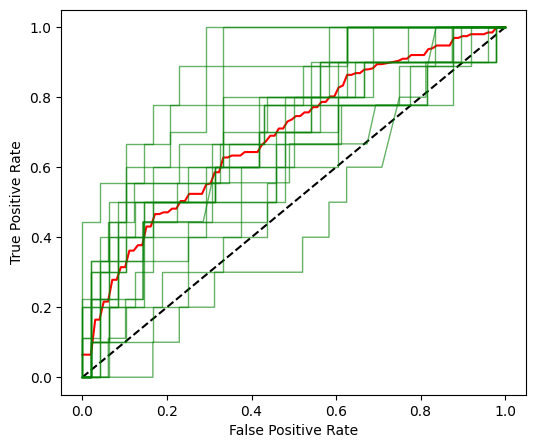

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

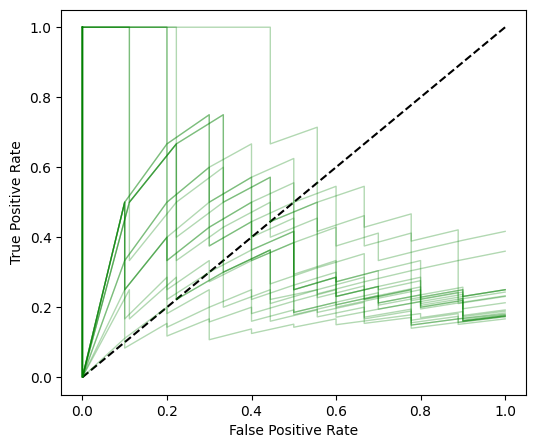

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)

# 1010

In [13]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=10,random_state=seed,n_repeats=10)

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

    #SMOTE로 타겟의 분포를 균등하게 조절
    smote = SMOTE(random_state=42)
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    
    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print(j,'번째')
    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
0 번째
Youden index threshold :  0.25169428753638523
roc_auc_score :  0.6666666666666667
acc :  0.8620689655172413
sensitivity :  0.6
specificity :  0.9166666666666666
pr_auc :  0.4682847027699969 

[[22  2]
 [ 2  3]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
1 번째
Youden index threshold :  0.4950503906191172
roc_auc_score :  0.575
acc :  0.5172413793103449
sensitivity :  0.8
specificity :  0.4583333333333333
pr_auc :  0.2866632006337889 

[[11 13]
 [ 1  4]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
2 번째
Youden index threshold :  0.20959555896679052
roc_auc_score :  0.8999999999999999
acc :  0.8275862068965517
sensitivity :  1.0
specificity :  0.7916666666666666
pr_auc :  0.4782539682539682 

[[19  5]
 [ 0  5]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
3 번째
Youden index threshold :  0.24499516512074215
roc_auc_score :  0.9333333333333333
acc :  0.9310344827586207
sensitivity :  1.

In [14]:
print('proba_score',np.mean(proba_score))
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.6788416666666669
re_score 0.7709999999999999
specifi_score 0.6983333333333333


[0.6666666666666667,
 0.575,
 0.8999999999999999,
 0.9333333333333333,
 0.925,
 0.5416666666666667,
 0.8166666666666667,
 0.33333333333333337,
 0.88,
 0.46874999999999994,
 0.45,
 0.7916666666666667,
 0.8583333333333334,
 0.775,
 0.8083333333333333,
 0.65,
 0.7250000000000001,
 0.7333333333333334,
 0.8099999999999999,
 0.90625,
 0.5,
 0.6583333333333333,
 0.65,
 0.47500000000000003,
 0.5916666666666666,
 0.6583333333333333,
 0.6833333333333333,
 0.6250000000000001,
 0.77,
 0.625,
 0.6916666666666667,
 0.5166666666666667,
 0.7083333333333334,
 0.9416666666666667,
 0.75,
 0.5250000000000001,
 0.625,
 0.65,
 0.7599999999999999,
 0.9791666666666667,
 0.5,
 0.75,
 0.6666666666666666,
 0.7833333333333333,
 0.7583333333333333,
 0.7666666666666666,
 0.6333333333333333,
 0.7333333333333334,
 0.53,
 0.44791666666666663,
 0.6333333333333333,
 0.55,
 0.8416666666666668,
 0.65,
 0.7083333333333334,
 0.7000000000000001,
 0.6333333333333334,
 0.8583333333333334,
 0.92,
 0.6354166666666666,
 0.8833333

In [16]:
CF_item = pd.DataFrame()
CF_item['proba_score'] = proba_score
CF_item['re_score'] = re_score
CF_item['specifi_score'] = specifi_score 
CF_item.to_csv('CF_LF_SMOTE1010.csv',index=False)

In [17]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP


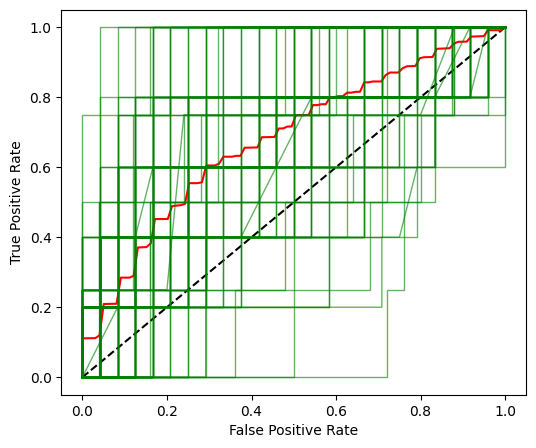

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

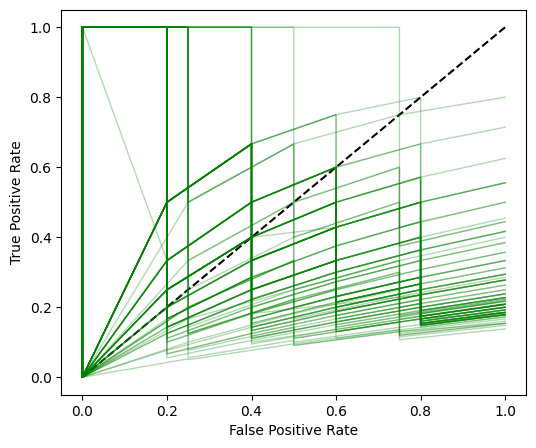

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)